<a href="https://colab.research.google.com/github/MariaZharova/VQA-examples/blob/main/%D0%A1_%D1%87%D0%B5%D0%B3%D0%BE_%D0%BD%D0%B0%D1%87%D0%B0%D1%82%D1%8C_%D0%B2_Data_Science%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# С чего начать в Data Science?

### В этом занятии мы:

⚡️Рассмотрим реализацию небольшой модели машинного обучения из семейства VQA (Visual Question Answering), которая по картинке отвечает на заданный пользователем вопрос. Подробнее можно почитать в авторской научной статье https://visualqa.org

⚡️Запустим более продвинутую модель YOLOv5 model, которая идентифицирует объекты на картинке (задача детекции).

⚡️В качестве бонуса заглянем на сайт )))))), на котором находится "всё несуществующее" - изображения людей, животных, предметов и т.д., сгенерированные нейронной сетью.

### Как работать с нотбуком

Мы будем работать с Google Colab - это бесплатная интерактивная облачная среда для работы с кодом от Google (аналог Jupyter Notebook в онлайн версии). Вам не нужно ничего скачивать или устанавливать - просто переходите по ссылке и начнём работу 💥

1. Нужно последовательно запускать ячейки с кодом - сначала нужно нажать на неё, а затем на треугольник запуска слева.

2. Выполнения одной ячейки может занимать некоторое время, за прогрессом можно следить по вращающемуся кружочку.

3. По окончании Вы увидите зелёную галочку.

4. Даже если ячейка не выполнилась, можете запускать следующую - они последовательно выполнятся в том порядке, в котором Вы их запустили.

5. Результат выполнения кода ячейки будет отображаться в поле под ней.

### ⭐️ Visual Question Answering

Теперь давайте запустим первую модель, которая отвечает на несложные вопросы по картинкам.

Принцип её работы заключается в следующем:

1. Преобразуем изображение в набор пикселей (численные данные).

2. Преобразуем вопрос в вектор, который также будет распознан моделью.

3. Передаём преобразованные данные в модель.

4. Получаем результат.

Для начала также установим и выгрузим все необходимые библиотеки:

In [ ]:
# еcли при выполнении этой ячейки возникнут красные ошибки - не беспокойтесь, 
# запускайте дальше, это ни на что не влияет
! pip install -U 'Pillow>=5.2.0'

In [ ]:
# подгружаем (импортируем) необходимые библиотеки
import os, sys
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [ ]:
# загружаем имплементацию модели с гит хаба
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

if not os.path.isfile('./2017-08-04_00.55.19.pth'):   # 81Mb model
    !wget https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
import model # from pytorch-vqa

#saved_state = torch.load('logs/2017-08-04_00:55:19.pth')
saved_state = torch.load('./2017-08-04_00.55.19.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1

saved_state.keys() 

dict_keys(['name', 'tracker', 'config', 'weights', 'eval', 'vocab'])

In [ ]:
# загружаем предопределенную модель
vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

Теперь приступим к загрузке изображений!
В третьей после этой по счёту ячейке, гле находятся ссылки, Вы можете указать ссылки на собственные изображения :)

In [ ]:
# импортируем ещё один необходмый для обработки изображений модуль
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

In [ ]:
# вспомогательные функции для перевода изображений в пригодный для подачи на вход модели вид
import resnet 
from PIL import Image
import torchvision.transforms as transforms

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 448  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)

In [ ]:
# здесь загружаем изображения, которые будем исследовать!
# вместо указанных ссылок можете вставить Ваши собственные (проверьте, чтобы был открыт доступ)
image_urls, image_path, image_files = [
    'https://www.pets4homes.co.uk/images/articles/2709/large/tabby-cat-colour-and-pattern-genetics-5516c44dbd383.jpg',
    'https://imgc.allpostersimages.com/img/print/posters/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
    'https://i.ytimg.com/vi/AIwlyly7Eso/hqdefault.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/9/9b/Black_pussy_-_panoramio.jpg',
    'https://www.thehappycatsite.com/wp-content/uploads/2017/06/siamese5.jpg',
    'https://c.pxhere.com/photos/15/e5/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg!d',
    'http://kitticats.com/wp-content/uploads/2015/05/cat4.jpg',
], './img/', []
os.makedirs('./img', exist_ok=True)
for url in image_urls:
    image_file=os.path.join(image_path, os.path.basename(url))
    image_files.append(image_file)
    if not os.path.isfile(image_file):
        !wget {url} --directory-prefix ./img/
image_files

--2022-05-17 00:59:09--  https://www.pets4homes.co.uk/images/articles/2709/large/tabby-cat-colour-and-pattern-genetics-5516c44dbd383.jpg
Resolving www.pets4homes.co.uk (www.pets4homes.co.uk)... 172.67.15.88, 104.22.2.186, 104.22.3.186, ...
Connecting to www.pets4homes.co.uk (www.pets4homes.co.uk)|172.67.15.88|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-17 00:59:10 ERROR 404: Not Found.

--2022-05-17 00:59:10--  http://kitticats.com/wp-content/uploads/2015/05/cat4.jpg
Resolving kitticats.com (kitticats.com)... failed: Name or service not known.
wget: unable to resolve host address ‘kitticats.com’


['./img/tabby-cat-colour-and-pattern-genetics-5516c44dbd383.jpg',
 './img/cat-black-jumping-off-wall_a-G-12469828-14258383.jpg',
 './img/hqdefault.jpg',
 './img/Black_pussy_-_panoramio.jpg',
 './img/siamese5.jpg',
 './img/cat_roof_home_architecture_building_roofs_animal_sit-536976.jpg!d',
 './img/cat4.jpg']

In [ ]:
v = resnet_layer4.image_to_features(image_files[1])
v.size()

torch.Size([1, 2048, 14, 14])

Теперь аналогично приступаем к обработке текста (необходимо для нашиз вопросов)

In [ ]:
# посомтрим на возможные слова для идентификации вопроса
vocab = saved_state['vocab']
vocab.keys() 
list(vocab['question'].items())[:5] 

[('the', 1), ('is', 2), ('what', 3), ('are', 4), ('this', 5)]

In [ ]:
# функция для перевода текста в численный набор данных (вектор)
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [ ]:
# посмотрим на возможные ответы 
# в послежних квадратных скобках стоит число 5 - т.е. на экран напечатается только первые 5 слов
# можете изменить этот параметр или вовсе убрать квадратные скобки и то, что находится в них - 
# тогда увидите полный список ответов
list(vocab['answer'].items())[:5]    

[('yes', 0), ('no', 1), ('2', 2), ('1', 3), ('white', 4)]

In [ ]:
# помещаем ответы в отдельную переменную - видим, что всего их 3000
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w
len(answer_words), answer_words[:10]

(3000, ['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green'])

In [ ]:
# Important things to know...
'colour' in qtoken_to_index, 'color' in qtoken_to_index, 'tabby' in answer_words

(False, True, True)

А теперь приступим к тестированию нашей модели

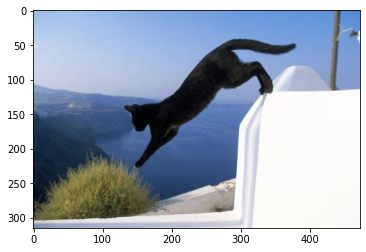

In [ ]:
# в первой строке указано число - это номер картинки (из той ячейки, где мы их загружали)
# в данном тестовом ноутбуке можете менять его от 0 до 6 (всего у нас было 7 картинок)
image_idx = 1
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

In [ ]:
v0 = resnet_layer4.image_to_features(image_filename)

In [ ]:
# здесь написано несколько тестовых вопросов, можете раскомментировать нужный :)
q, q_len = encode_question("what color is cat?")
#q, q_len = encode_question("what color is the cat's fur")
#q, q_len = encode_question("is the cat jumping up or down")
q, q_len

(tensor([  2,   1,  43, 576, 109,  25, 168], device='cuda:0'),
 tensor(7, device='cuda:0'))

In [ ]:
# это текст в векторном представлении (то, что пойдёт на вход модели)
ans = vqa_net(v0, q.unsqueeze(0), q_len.unsqueeze(0))
ans.data.cpu()[0:10]

tensor([[-12.7777, -12.9656, -18.9573,  ..., -49.5790, -41.9412, -56.8924]])

In [ ]:
# здесь выод ответа на Ваш вопрос
_, answer_idx = ans.data.cpu().max(dim=1)
answer_words[ answer_idx ]

'down'

Можно создать конструкцию для задания сразу нескольких вопросов, ответы на них будут выведены все сразу

In [ ]:
# опять вспомогательные функции ...
def vqa_single_softmax(im_features, q_str):
    q, q_len = encode_question(q_str)
    ans = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return ans.data.cpu()

def vqa(image_filename, question_arr):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    for question_str in question_arr:
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)  

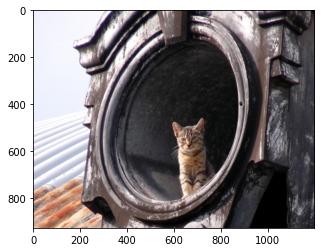

no       <- is there a people in the picture
yes      <- is there a cat in the picture
tabby    <- what breed of a cat
yes      <- does cat have a tail
white    <- what color of the background
calico   <- what color is the cat
green    <- what color are the cat's eyes


In [ ]:
# задаём как всегда номер катинки (в первой строке)
# а дальше задаём вопросы - можете тоже их менять
image_idx = 5  # 6 

vqa(image_files[image_idx], [
    "is there a people in the picture",
    "is there a cat in the picture",
    "what breed of a cat",
    "does cat have a tail",
    "what color of the background",
    "what color is the cat",
    "what color are the cat's eyes",
])

### ⭐️ YOLOv5 model

Это гораздо более продвинутая модель, над которой трудилась команда из более чем 200 человек, так подробно её код мы рассматривать не будем. Он помещён в отдельный модуль, который разом можно скачать с GitHub и запустить одной строчкой - скачаем его себе в ноутбук и посмотрим на результаты работы.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-196-g614ef11 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/78.2 GB disk)


detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-196-g614ef11 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

100% 14.1M/14.1M [00:00<00:00, 116MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.031s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.034s)
Speed: 0.9ms pre-process, 32.5ms inference, 13.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


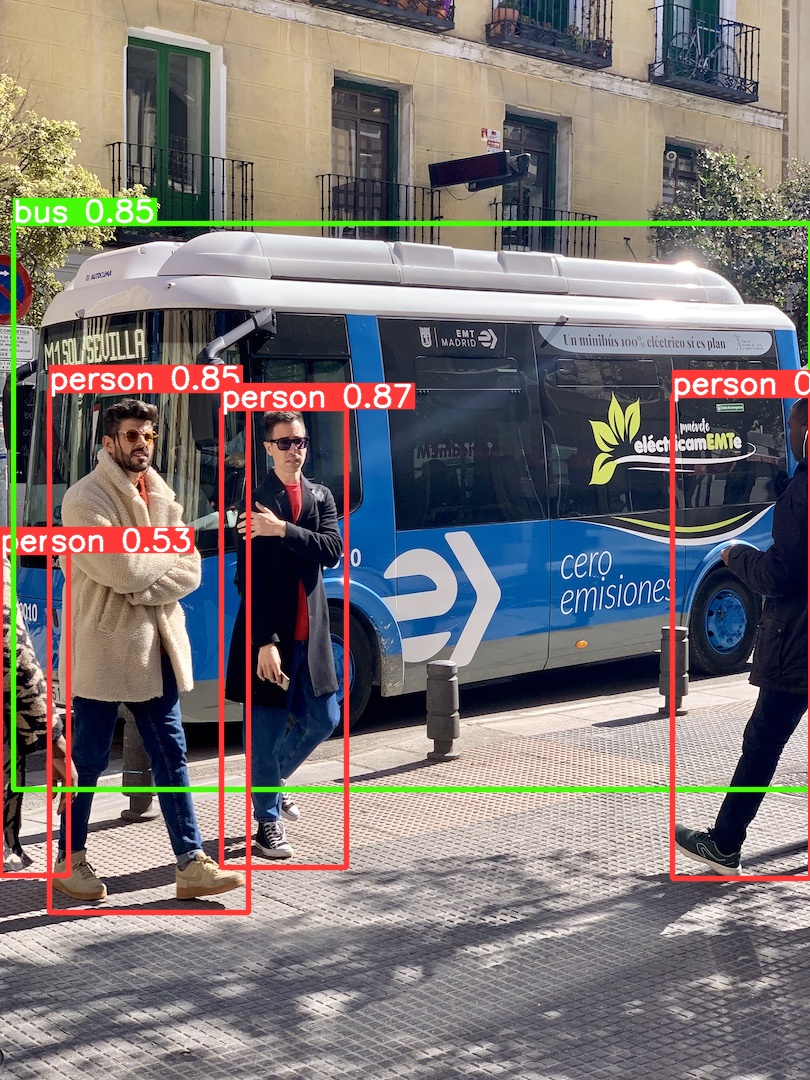

In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images
display.Image(filename='runs/detect/exp/bus.jpg', width=600)

Видим, что на картинке модель обнаружила несколько человек - в подписи находится предполагаемое название объекта и вероятность, с которой он относится к данному типу.

### ⭐️ This X Does Not Exist

И в качестве бонуса заглянем на сайт https://thisxdoesnotexist.com - на нём находятся так называемые "несуществующие" объекты - картинки, полностью сгенерированные нейронной сетью.

# Всем спасибо за внимание!🔥